In [1]:
# # import mne
# import numpy as np
# mne.set_log_level('WARNING')

In [2]:
# raw = mne.io.read_raw_fif("S:\\PolySecLabProjects\\eeg-image-decoding\\data\\all-joined-1\\eeg\\preprocessed\\subj01_session1_eeg.fif", preload=True)
# events = mne.find_events(raw)

In [3]:
# original_epochs = mne.Epochs(raw, events, tmin=-0.05, tmax=0.6, preload=True)
# original_epochs = original_epochs.resample(250)

In [4]:
# fig = original_epochs.compute_psd().plot()

In [5]:
# fig = original_epochs.average().plot_joint()

In [6]:
# raw = raw.drop_channels(['Status'])
# info = raw.info

In [7]:
# np_epochs = np.load("S:\\PolySecLabProjects\\eeg-image-decoding\\data\\all-joined-1\\eeg\\epochs\\650ms-250Hz\\subj01_session1_epochs_sr.npy")
# epochs = mne.EpochsArray(np_epochs, info, events=events)

In [8]:
# fig = epochs.compute_psd().plot()

In [9]:
# fig = epochs.average().plot_joint()

In [10]:
# original_epochs.get_data().shape, epochs.get_data().shape

In [11]:
import mne
import numpy as np
mne.set_log_level('WARNING')

In [12]:
raw = mne.io.read_raw_fif("S:\\PolySecLabProjects\\eeg-image-decoding\\data\\all-joined-1\\eeg\\preprocessed\\subj01_session1_eeg.fif", preload=True)
events = mne.find_events(raw)

In [13]:
print("Creating original epochs...")
original_epochs = mne.Epochs(raw, events, tmin=-0.05, tmax=0.6, preload=True)
original_epochs = original_epochs.resample(250)

Creating original epochs...


In [14]:
print(f"Original epochs shape: {original_epochs.get_data().shape}")
print(f"Original sampling rate: {original_epochs.info['sfreq']} Hz")
print(f"Original time range: {original_epochs.times[0]:.3f} to {original_epochs.times[-1]:.3f} seconds")

Original epochs shape: (3839, 65, 163)
Original sampling rate: 250.0 Hz
Original time range: -0.051 to 0.597 seconds


In [15]:
print("Loading numpy epochs...")
np_epochs = np.load("S:\\PolySecLabProjects\\eeg-image-decoding\\data\\all-joined-1\\eeg\\epochs\\650ms-250Hz\\subj01_session1_epochs_sr.npy")
print(f"Numpy epochs shape: {np_epochs.shape}")
print(f"Expected: (n_epochs, n_channels, n_timepoints)")

Loading numpy epochs...
Numpy epochs shape: (3839, 64, 163)
Expected: (n_epochs, n_channels, n_timepoints)


In [16]:
print("Preparing info for numpy epochs...")

# Remove Status channel if present
if 'Status' in raw.ch_names:
    raw_clean = raw.copy().drop_channels(['Status'])
    print("Removed 'Status' channel")
else:
    raw_clean = raw.copy()

info = raw_clean.info.copy()

# Check if channel count matches
print(f"Info channels: {len(info['ch_names'])}")
print(f"Numpy channels: {np_epochs.shape[1]}")

if len(info['ch_names']) != np_epochs.shape[1]:
    print(f"Channel count mismatch! Adjusting...")
    
    # If numpy has fewer channels, subset the info
    if np_epochs.shape[1] < len(info['ch_names']):
        print("Subsetting info to match numpy epochs...")
        keep_channels = info['ch_names'][:np_epochs.shape[1]]
        info = mne.pick_info(info, mne.pick_channels(info['ch_names'], keep_channels))
        print(f"Kept channels: {info['ch_names']}")

# Fix sampling frequency - use with_info to avoid RuntimeError
target_sfreq = 250.0
if info['sfreq'] != target_sfreq:
    print(f"Adjusting sampling frequency from {info['sfreq']} to {target_sfreq} Hz")
    # Create a temporary raw object to properly set sfreq
    temp_data = np.zeros((len(info['ch_names']), 1000))  # Dummy data
    temp_raw = mne.io.RawArray(temp_data, info, verbose=False)
    temp_raw = temp_raw.resample(target_sfreq, verbose=False)
    info = temp_raw.info.copy()
else:
    print(f"Sampling frequency already correct: {info['sfreq']} Hz")

Preparing info for numpy epochs...
Removed 'Status' channel
Info channels: 64
Numpy channels: 64
Adjusting sampling frequency from 512.0 to 250.0 Hz


In [17]:
print(f"Events count: {len(events)}")
print(f"Numpy epochs count: {np_epochs.shape[0]}")

if len(events) != np_epochs.shape[0]:
    print(f"Event count mismatch! Subsetting events...")
    events_subset = events[:np_epochs.shape[0]]
    print(f"Using first {len(events_subset)} events")
else:
    events_subset = events
    print("Event count matches!")

Events count: 3839
Numpy epochs count: 3839
Event count matches!


In [18]:
print("Creating MNE epochs from numpy array...")

# Calculate the correct time range based on data shape
n_times = np_epochs.shape[2]
tmin = -0.05
sfreq = 250
calculated_duration = (n_times - 1) / sfreq
calculated_tmax = tmin + calculated_duration

print(f"Time points in data: {n_times}")
print(f"Calculated duration: {calculated_duration:.3f} seconds")
print(f"Calculated tmax: {calculated_tmax:.3f} seconds")

epochs_from_numpy = mne.EpochsArray(
    np_epochs, 
    info, 
    events=events_subset,
    tmin=tmin,  # Match your original tmin
    verbose=False
)

print(f"Created epochs shape: {epochs_from_numpy.get_data().shape}")
print(f"Created epochs sampling rate: {epochs_from_numpy.info['sfreq']} Hz")
print(f"Created epochs time range: {epochs_from_numpy.times[0]:.3f} to {epochs_from_numpy.times[-1]:.3f} seconds")

Creating MNE epochs from numpy array...
Time points in data: 163
Calculated duration: 0.648 seconds
Calculated tmax: 0.598 seconds
Created epochs shape: (3839, 64, 163)
Created epochs sampling rate: 250.0 Hz
Created epochs time range: -0.048 to 0.600 seconds


In [19]:
print("=== ALIGNMENT VERIFICATION ===")
print(f"Original epochs shape: {original_epochs.get_data().shape}")
print(f"Numpy epochs shape: {epochs_from_numpy.get_data().shape}")
print(f"Original time points: {len(original_epochs.times)}")
print(f"Numpy time points: {len(epochs_from_numpy.times)}")
print(f"Original channels: {len(original_epochs.ch_names)}")
print(f"Numpy channels: {len(epochs_from_numpy.ch_names)}")

# Check data ranges
orig_data = original_epochs.get_data()
numpy_data = epochs_from_numpy.get_data()
print(f"Original data range: [{orig_data.min():.6f}, {orig_data.max():.6f}]")
print(f"Numpy data range: [{numpy_data.min():.6f}, {numpy_data.max():.6f}]")

=== ALIGNMENT VERIFICATION ===
Original epochs shape: (3839, 65, 163)
Numpy epochs shape: (3839, 64, 163)
Original time points: 163
Numpy time points: 163
Original channels: 65
Numpy channels: 64
Original data range: [-62.018484, 452.722311]
Numpy data range: [-5.579414, 5.723695]


In [26]:
print("Plotting PSDs...")

# Original epochs PSD
fig1 = original_epochs.compute_psd(fmin=1, fmax=125).plot()
fig1.suptitle('GT Epochs - PSD')

Plotting PSDs...


s:\PolySecLabProjects\eeg-image-decoding\env\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Text(0.5, 0.98, 'GT Epochs - PSD')

In [27]:
fig2 = epochs_from_numpy.compute_psd(fmin=1, fmax=125).plot()
fig2.suptitle('SR Epochs - PSD')

s:\PolySecLabProjects\eeg-image-decoding\env\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Text(0.5, 0.98, 'SR Epochs - PSD')

In [22]:
erp_times = [0.08, 0.1, 0.17, 0.3, 0.4]  # N1, P1, N170, N300, P400
erp_labels = ['N1 (80ms)', 'P1 (100ms)', 'N170 (170ms)', 'N300 (300ms)', 'P400 (400ms)']

# Filter for available times
valid_erp_times = [t for t in erp_times if original_epochs.times[0] <= t <= original_epochs.times[-1]]
valid_erp_labels = [erp_labels[i] for i, t in enumerate(erp_times) if original_epochs.times[0] <= t <= original_epochs.times[-1]]

ERP time points: ['N1 (80ms)', 'P1 (100ms)', 'N170 (170ms)', 'N300 (300ms)', 'P400 (400ms)']


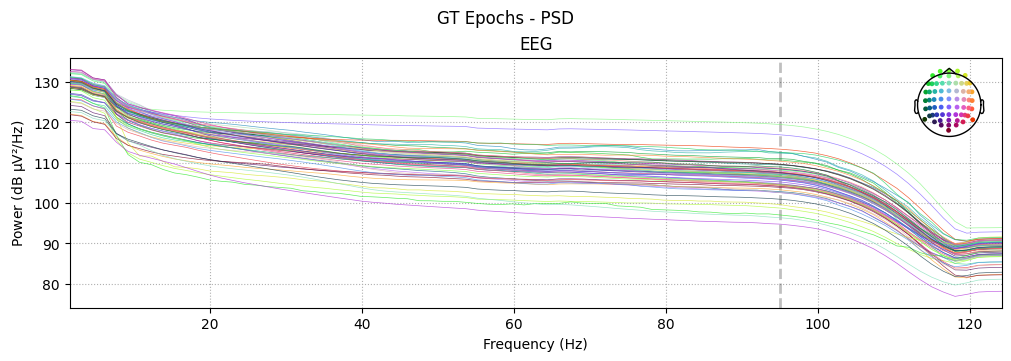

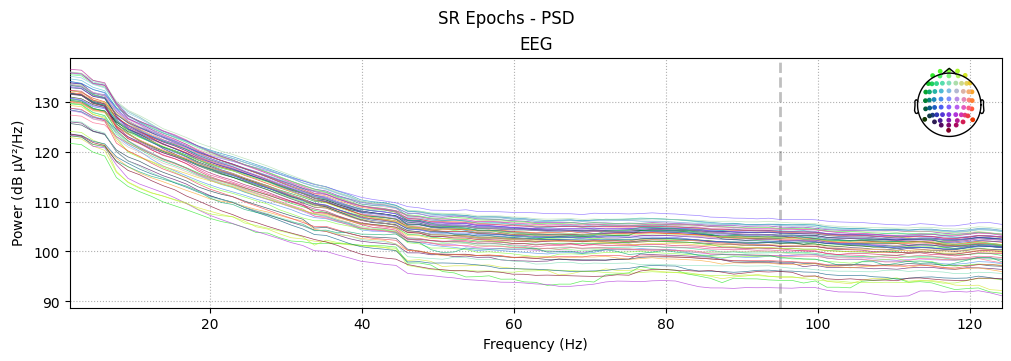

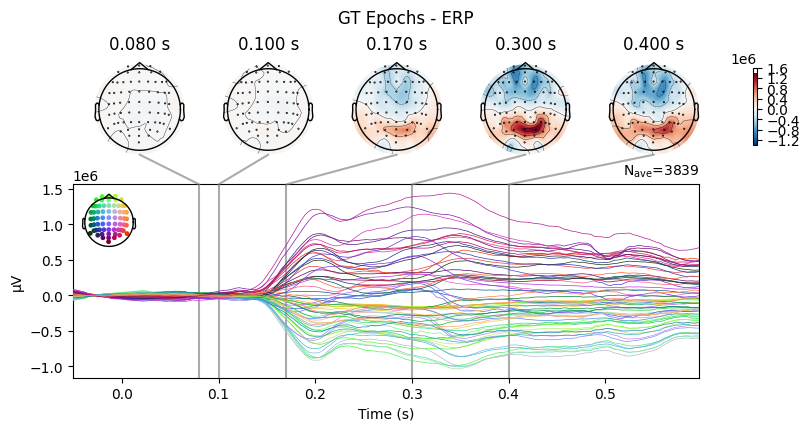

In [28]:
if valid_erp_times:
    print(f"ERP time points: {valid_erp_labels}")
    
    # Original ERP analysis
    fig3 = original_epochs.average().plot_joint(
        title=f'GT Epochs - ERP',
        times=valid_erp_times,
        ts_args={'time_unit': 's'}
    )

ERP time points: ['N1 (80ms)', 'P1 (100ms)', 'N170 (170ms)', 'N300 (300ms)', 'P400 (400ms)']


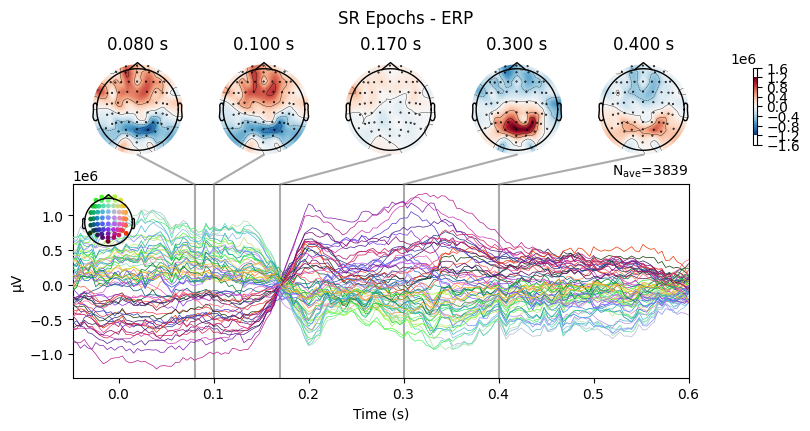

In [29]:
if valid_erp_times:
    print(f"ERP time points: {valid_erp_labels}")
    
    # Original ERP analysis
    fig4 = epochs_from_numpy.average().plot_joint(
        title=f'SR Epochs - ERP',
        times=valid_erp_times,
        ts_args={'time_unit': 's'}
    )